In [1]:
import sys 
import os
sys.path.append(r'/Users/kostastsampourakis/Desktop/code/Python/projects/neuralssm/src/neuralssm')
import argparse
import jax.numpy as jnp
import jax.random as jr
import time
import util.io
import experiment_descriptor as ed
import misc
import util.plot
from util.misc import get_exp_dir, get_exp_data
import matplotlib.pyplot as plt
import tensorflow_probability.substrates.jax.distributions as tfd # type: ignore
import main 
exp_root = '/Users/kostastsampourakis/Desktop/code/Python/projects/neuralssm/src/neuralssm/exps'

## View experiment

In [2]:
view = True

if view:

    abc_exp_dir = get_exp_dir('smc_abc', 'lgssm', state_dim=6, emission_dim=6, num_timesteps=200, vars='d4', num_prt = 100, qmax= 0.7, sigma=2.0)
    out_abc = get_exp_data(abc_exp_dir, 1, 10)

    # snl_exp_dir = get_exp_dir('snl', 'lgssm', state_dim=1, emission_dim=1, num_timesteps=100, vars='d4', num_samples=100, num_rounds=5, train_on='best', subsample=None, mcmc_steps=1000, lag=-1, dhidden=32)
    # tsnl_exp_dir = get_exp_dir('tsnl', 'lgssm', state_dim=1, emission_dim=1, num_timesteps=100, vars='d4', num_samples=10, num_rounds=5, train_on='best', subsample=1.0, mcmc_steps=1000, lag=33, dhidden=32)

    # out_snl = get_exp_data(snl_exp_dir, 1, 10)
    # out_tsnl = get_exp_data(tsnl_exp_dir, 1, 10)

Loading trial 1...
Entry all_dists not in file.
Entry mll not in file.
Entry mmd not in file.
Entry all_emissions not in file.
Entry posterior not in file.
Entry model not in file.
Entry props not in file.
Loading trial 2...
Entry all_dists not in file.
Entry mll not in file.
Entry mmd not in file.
Entry all_emissions not in file.
Entry posterior not in file.
Entry model not in file.
Entry props not in file.
Loading trial 3...
Entry all_dists not in file.
Entry mll not in file.
Entry mmd not in file.
Entry all_emissions not in file.
Entry posterior not in file.
Entry model not in file.
Entry props not in file.
Loading trial 4...
Entry all_dists not in file.
Entry mll not in file.
Entry mmd not in file.
Entry all_emissions not in file.
Entry posterior not in file.
Entry model not in file.
Entry props not in file.
Loading trial 5...
Entry all_dists not in file.
Entry mll not in file.
Entry mmd not in file.
Entry all_emissions not in file.
Entry posterior not in file.
Entry model not in f

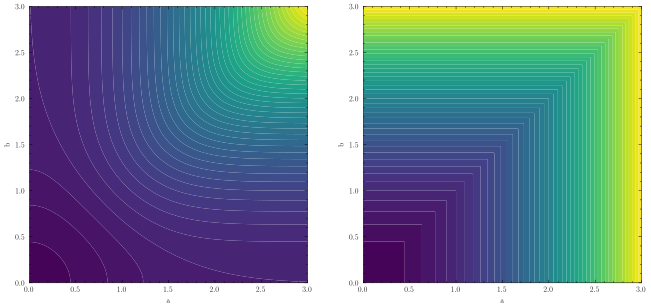

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from jax.scipy.special import logsumexp as lse

# Create a grid of values for a and b
a = np.linspace(0, 3, 300)
b = np.linspace(0, 3, 300)
A, B = np.meshgrid(a, b)

# Compute the function: log(exp(-a^2) + exp(-b^2))
Z = -lse(np.array([-A**2, -B**2]), axis=0)  # logsumexp for numerical stability
W = -jnp.min(np.array([-A**2, -B**2]), axis=0)

# Plotting
fig, ax = plt.subplots(1, 2, figsize=(11, 5))
ax[0].contourf(A, B, Z, levels=50)
ax[0].set_xlabel('a')
ax[0].set_ylabel('b')

ax[1].contourf(A, B, W, levels=50)
ax[1].set_xlabel('a')
ax[1].set_ylabel('b')

# 3D Plotting
# fig, ax = plt.subplots(1, 2, figsize=(11, 5), projection='3d')
fig = plt.figure(figsize=(15, 5))
ax0 = fig.add_subplot(111, projection='3d')
ax0.plot_surface(A, B, Z, cmap='viridis', edgecolor='none')
ax0.set_xlabel('a')
ax0.set_ylabel('b')
ax0.set_zlabel('Function value')
ax0.set_title('LSE')

ax1 = fig.add_subplot(121, projection='3d')
ax1.plot_surface(A, B, W, cmap='viridis', edgecolor='none')
ax1.set_xlabel('a')
ax1.set_ylabel('b')
ax1.set_zlabel('Function value')
ax1.view_init(elev=30, azim=30)
ax1.set_title('min')

plt.tight_layout()
plt.show()

# Plot ACFS

In [3]:
from util.param import sample_prior
from util.sample import map_sims
from util.train import to_train_array
from util.numerics import compute_acf
from simulators import lgssm, svssm, sirssm, lvssm
from matplotlib.patches import Patch


def get_acf_plot(key, ssm, max_lag, state_dim, emission_dim, num_timesteps, target_vars):

    setup = ssm.setup(state_dim, emission_dim, 0, target_vars)
    ssmodel = setup['ssm']
    props = setup['props']
    info = setup['exp_info']

    key, subkey = jr.split(key)
    params = sample_prior(subkey, props, 1)
    acfs_all_runs = []
    states_all_runs = []
    emissions_all_runs = []

    for param in params:

        cp = to_train_array(param, props)
        key, subkey = jr.split(key)
        states, emissions = map_sims(subkey, cp, props, ssmodel, num_timesteps)
        states_all_runs.append(states)
        emissions_all_runs.append(emissions)
        acfs = compute_acf(emissions, max_lag)
        acfs_all_runs.append(acfs)

    acfs_all_runs = jnp.array(acfs_all_runs)
    states_all_runs = jnp.array(states_all_runs)
    emissions_all_runs = jnp.array(emissions_all_runs)
    acf_mean = acfs_all_runs.mean(0)
    maxx = jnp.max(acf_mean)
    custom_patch = Patch(color='none', label=info['sim'].upper())

    return acf_mean, maxx, custom_patch

ssms = [lgssm, svssm, lvssm, sirssm]
state_dims = [10, 1, 2, 3]
emission_dims = [10, 1, 1, 1]
target_vars = [['d4'],[ 'd4'],[ 'd3'], ['d3']]

outputs = {
    'lgssm': {
        'means': [],
        'maxxs': []
    },

    'svssm': {
        'means': [],
        'maxxs': []
    },

    'lvssm': {
        'means': [],
        'maxxs': []
    },

    'sirssm': {
        'means': [],
        'maxxs': []
    }
}

figs = []
axs = []

key = jr.PRNGKey(0)

for i, ssm in enumerate(ssms):

    for trial in range(10):

        key, subkey = jr.split(key)
        mean, maxx, patch = get_acf_plot(subkey, ssm, 100, state_dims[i], 1, 200, target_vars[i])

        outputs[ssm.__name__.split('.')[-1]]['means'].append(mean)
        outputs[ssm.__name__.split('.')[-1]]['maxxs'].append(maxx)

    outputs[ssm.__name__.split('.')[-1]]['patch'] = patch

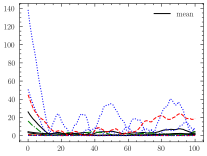

In [4]:
modname = 'lgssm'
mean = jnp.mean(jnp.array(outputs[modname]['means']).T, axis=1)
plt.plot(mean, label='mean')
plt.plot(jnp.array(outputs[modname]['means']).T)
plt.legend()
plt.show()

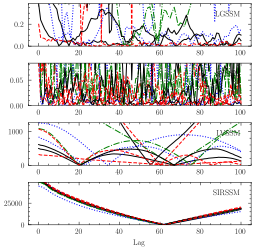

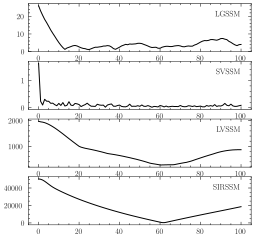

In [5]:
fig, ax = plt.subplots(4, 1, figsize=(4, 4))

for i, output in enumerate(outputs):

    means = jnp.array(outputs[output]['means']).T
    maxxs = jnp.array(outputs[output]['maxxs'])
    patch = outputs[output]['patch']

    ax[i].plot(means)
    ax[i].set_ylim(0, maxxs[i])
    ax[i].legend(handles=[patch], loc='upper right')

ax[3].set_xlabel('Lag')
plt.subplots_adjust(hspace=0.4)  # increase space between plots

fig, ax = plt.subplots(4, 1, figsize=(4, 4))

for i, output in enumerate(outputs):

    means = jnp.array(outputs[output]['means']).T
    patch = outputs[output]['patch']

    ax[i].plot(jnp.mean(means, axis=1))
    ax[i].legend(handles=[patch], loc='upper right')